In [9]:
import gymnasium as gym
import text_flappy_bird_gym

if __name__ == "__main__":
    env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)

# Implement Expected SARSA

In [10]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [20]:
class Expected_SARSA:
    def __init__(self, space_size, action_size, gamma=1):
        """
        Calculates optimal policy Expected SARSA.
        This code does NOT support TD lambda but only TD(0)
        """
        # the discount factor
        self.gamma = gamma

        # size of system
        self.space_size = space_size  # as tuple
        self.action_size = action_size

        # where to save returns
        self.Qvalues = np.zeros((*self.space_size, self.action_size))

    def get_action_epsilon_greedy(self, s):
        """
        Chooses action at random using an epsilon-greedy policy wrt the current Q(s,a).
        """
        ran = np.random.rand()

        if ran < self.epsilon:
            prob_actions = np.ones(self.action_size) / self.action_size

        else:
            best_value = np.max(self.Qvalues[(*s,)])

            best_actions = self.Qvalues[(*s,)] == best_value

            prob_actions = best_actions / np.sum(best_actions)

        a = np.random.choice(self.action_size, p=prob_actions)
        return a

    def policy(self, s):
        """
        Probabilities from an epsilon-greedy policy wrt the current Q(s,a).
        """
        policy = np.ones(self.action_size) / self.action_size * self.epsilon

        best_value = np.max(self.Qvalues[(*s,)])
       
        best_actions = self.Qvalues[(*s,)] == best_value
        policy += best_actions / np.sum(best_actions) * (1 - self.epsilon)
        return policy

    def single_step_update(self, s, a, r, new_s, new_a, done):

        # If we reached the terminal state
        if done:
            deltaQ = r + 0 - self.Qvalues[(*s, a)]
            self.Qvalues += self.lr_v * deltaQ

        else:
            deltaQ = (
                r
                + self.gamma * np.dot(self.Qvalues[(*new_s,)], self.policy(new_s))
                - self.Qvalues[(*s, a)]
            )
        self.Qvalues[(*s, a)] += self.lr_v * deltaQ
    


    def train(self, n_episodes=10000, tstar=None, epsilon_0=0.2,k_epsilon=0, lr_v0=0.15, k_lr=0):
        """
        This function trains the agent using n_episodes.
        The default parameters use constant learning rate and epsilon (k = 0 in both cases)
        Otherwise a decaying rate is implemented after a starting point t0 (see README for more details)
        """

        Actions = [i for i in range(self.action_size)]
        self.n_episodes = n_episodes

        # Add the following attributes to the class
        self.performance_traj = np.zeros(n_episodes)  # To store cumulative reward at every game

        # Parameters for epsilon decay
        self.epsilon_0 = epsilon_0  # Needed to name the plots
        self.epsilon = epsilon_0  # Needed to keep track of current epsilon
        self.k_epsilon = k_epsilon

        # Parameters for learning rate decay
        self.lr_v0 = lr_v0
        self.lr_v = lr_v0
        self.k_lr = k_lr

        if tstar is None:
            tstar = 2.5 * n_episodes

        count = 0  # counter variable needed to see when to start decaying rates

        # Run over episodes
        for i in range(n_episodes):
            done = False
            s, info = env.reset()
            a = self.get_action_epsilon_greedy(s)
            act = Actions[a]

            while not done:
                count += 1

                # Perform one "step" in the environment
                new_s, r, done, _, info = env.step(act)

                # Keep track of rewards for one episode
                self.performance_traj[i] += r

                # Choose new action index
                new_a = self.get_action_epsilon_greedy(new_s)
                act = Actions[new_a]

                self.single_step_update(s, a, r, new_s, new_a, done)

                if count > tstar:
                    self.epsilon = epsilon_0 / (1.0 + self.k_epsilon * (count - tstar) ** 1.05)
                    self.lr_v = lr_v0 / (1 + self.k_lr * (count - tstar) ** 0.75)

                a = new_a
                s = new_s

    def plot_traj(self, cumulative=True, local=False, save_img=False, save_traj=False):
        title = "SARSA"

        plot_indexes = np.arange(0, self.n_episodes + 1, 20, dtype=int)
        plot_indexes[-1] = plot_indexes[-1] - 1

        plt.plot(plot_indexes, self.performance_traj[plot_indexes])

        if cumulative:
            cumulative_mean = np.cumsum(self.performance_traj) / np.arange(1, len(self.performance_traj) + 1)
            plt.plot(plot_indexes, cumulative_mean[plot_indexes], label="Cumulative mean")
        if local:
            window_size = 100
            local_mean_SARSA = np.convolve(self.performance_traj, np.ones(window_size) / window_size, mode="valid")
            plt.plot(plot_indexes[plot_indexes < local_mean_SARSA.shape[0]],
                     local_mean_SARSA[plot_indexes[plot_indexes < local_mean_SARSA.shape[0]]],
                     label=" Local Mean", color = 'red')
            
        plt.xlabel("Episode")
        plt.ylabel("Episode reward")
        plt.legend()
        plt.suptitle(f"{title} control cumulative rewards")

        plt.title(f"$\epsilon_0$ = {self.epsilon_0}, $k_\epsilon$ = {self.k_epsilon}, $\\alpha_0$ = {self.lr_v0}, $k_{{\\alpha}}$ = {self.k_lr}")
        plt.tight_layout()

        if save_img:
            name = (
                "Plots/Exp_SARSA_plots/Exp_SARSA_k_alpha_"
                + str(self.k_lr)
                + "k_epsilon"
                + str(self.k_epsilon)
                + ".png"
            )
            plt.savefig(name)
        plt.show()

        if save_traj:
            name = (
                "Trajectories/Exp_SARSA_trajectories/Exp_SARSA_k_alpha_"
                + str(self.k_lr)
                + "k_epsilon"
                + str(self.k_epsilon)
                + ".txt"
            )
            array_str = " ".join(str(element) for element in self.performance_traj)
            file = open(name, 'w+')
            file.write(array_str)
            file.close()

In [12]:
observation_space = (env.observation_space[0].n, env.observation_space[1].n)
n_episodes = 10000

In [13]:
lambdas = [0.0, 0.2, 0.5, 0.8]
k_epsilons = [0.00005, 0.0005, 0.005, 0.05]
k_lrs = [0.00003, 0.0003, 0.003, 0.03]

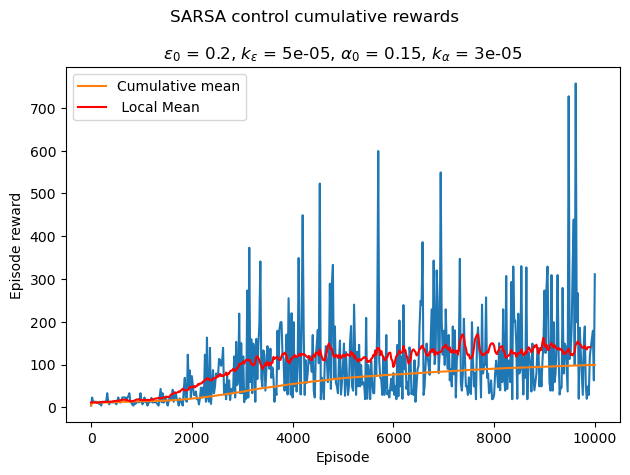

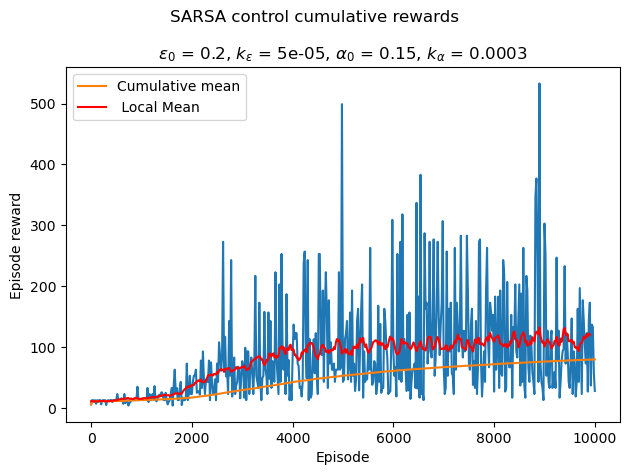

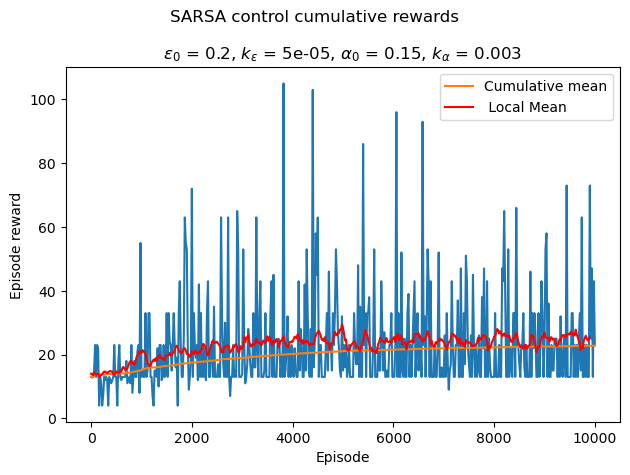

KeyboardInterrupt: 

In [24]:
for j in k_epsilons:
    for l in k_lrs:
        e_sarsa = Expected_SARSA(space_size=observation_space, action_size=2, gamma=1)
        e_sarsa.train(n_episodes=n_episodes, k_epsilon=j, k_lr=l)
        e_sarsa.plot_traj(cumulative=True, local=True, save_img=True, save_traj=True)

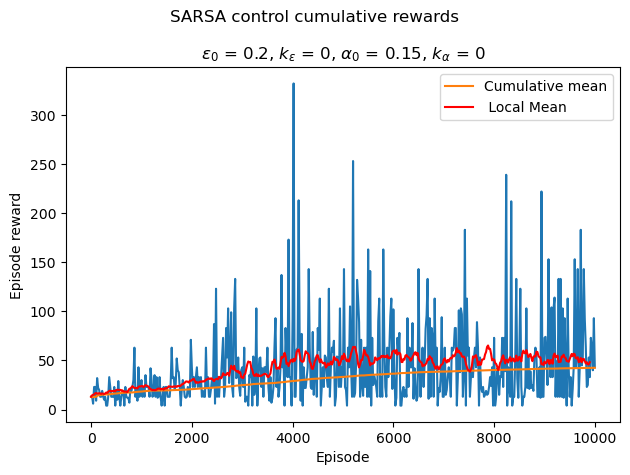

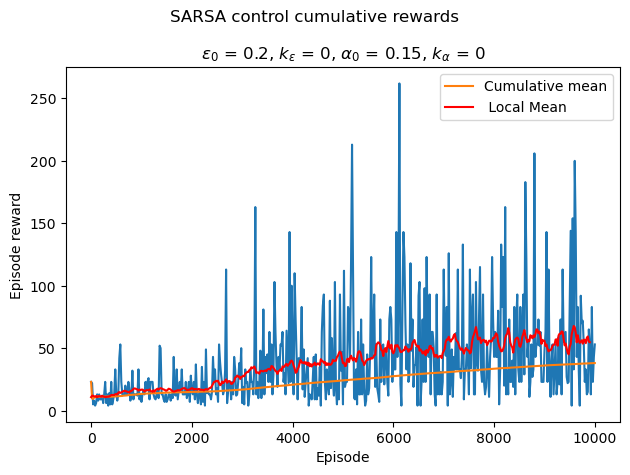

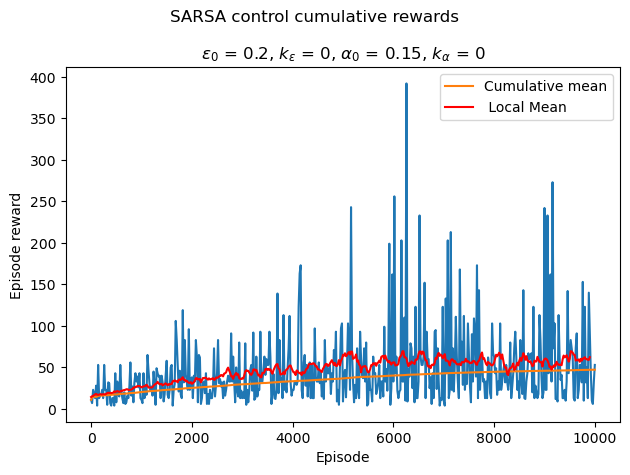

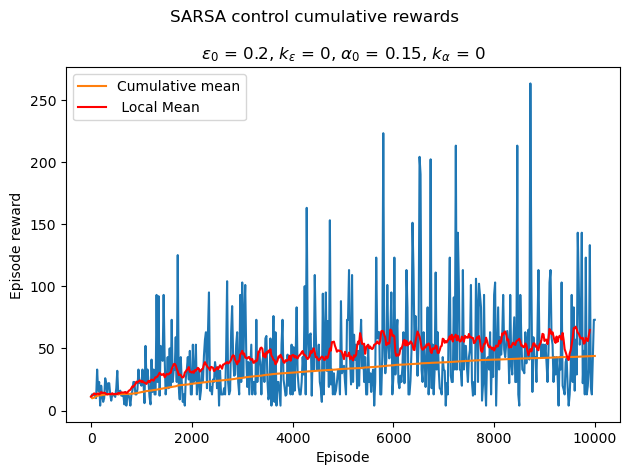

In [21]:
k_e = 0
k_lr = 0
e_sarsa = Expected_SARSA(space_size=observation_space, action_size=2, gamma=1)
e_sarsa.train(n_episodes=n_episodes, k_epsilon=k_e, k_lr=k_lr)
e_sarsa.plot_traj(cumulative=True, local=True, save_img=True, save_traj=True)